## Import Libraries

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import RandomizedSearchCV

## Upload Data

In [ ]:
train_data = pd.read_csv('/content/train_data.csv')
test_data = pd.read_csv('/content/test_data.csv')

train_data.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_win,ID
0,871,22,0,4,2,110,2,3,11,3,...,0,10,1,0.875000,0,0,6,3,True,a363534a6344f1b0be1d7ba2c4047d9a
1,2549,22,0,17,0,114,16,2,12,24,...,1,10,0,0.535714,1,0,0,0,True,a0ba4ef0965f56d2eba69c2b9ef33353
2,1841,22,0,8,1,100,2,11,12,2,...,0,13,0,0.727273,0,0,0,0,True,18873e56c2142af326b4e08ca41df63a
3,2211,22,7,11,3,32,14,3,11,21,...,0,1,0,0.347826,0,0,0,0,True,c143931a6a8b3fb55a8ef6b9f30c6933
4,458,22,7,1,0,68,3,0,0,15,...,0,6,0,0.000000,0,0,1,1,True,5a324d8b37522e9f9684493465720023


In [ ]:
# We will save test IDs in a separate variable since we are going to need them for submission
test_ids = test_data[['ID']]

## Exploratory Data Analysis (EDA)

In [ ]:
train_data.shape

(29675, 247)

In [ ]:
test_data.shape

(10000, 246)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29675 entries, 0 to 29674
Columns: 247 entries, game_time to ID
dtypes: bool(1), float64(30), int64(215), object(1)
memory usage: 55.7+ MB


In [ ]:
# Here we check whether any of the columns contain null values in the train set
print(train_data.isna().sum().tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# Here we check whether any of the columns contain null values in the test set
print(test_data.isna().sum().tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


As we can see, there are no missing values in either of the datasets.

In [ ]:
# Convert the target column into integer
train_data['radiant_win'] = train_data['radiant_win'].astype(int)

In [ ]:
train_data['radiant_win'].value_counts()

,count
radiant_win,
1,15526
0,14149


The dataset is balanced as the class distribution is roughly the same.

In [ ]:
# Drop the ID column from train and test sets
train_data.drop('ID', axis=1, inplace=True)
test_data.drop('ID', axis=1, inplace=True)

In [ ]:
train_data.describe()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_win
count,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000,...,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000,29675.000000
mean,1145.695333,19.592957,4.772738,6.531997,7.351879,51.103960,3.155619,3.256917,4.666992,6.335771,...,1.038585,0.341769,4.694457,0.088795,0.414476,0.302072,0.024971,1.276765,0.789250,0.523201
std,768.974419,6.297211,3.260444,6.500606,13.561608,34.590915,3.744580,3.279818,5.225634,8.273026,...,3.556953,0.962948,4.645499,0.284453,0.267860,0.740563,0.170487,2.602252,2.448526,0.499470
min,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,518.000000,22.000000,0.000000,1.000000,0.000000,20.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.230769,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1043.000000,22.000000,7.000000,4.000000,3.000000,44.000000,2.000000,2.000000,3.000000,3.000000,...,0.000000,0.000000,3.000000,0.000000,0.440000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1654.000000,22.000000,7.000000,10.000000,9.000000,81.000000,5.000000,5.000000,7.000000,9.000000,...,0.000000,0.000000,7.000000,0.000000,0.600000,0.000000,0.000000,1.000000,0.000000,1.000000
max,4742.000000,23.000000,7.000000,43.000000,291.000000,120.000000,32.000000,27.000000,40.000000,84.000000,...,132.000000,29.000000,57.000000,1.000000,2.000000,9.000000,4.000000,26.000000,47.000000,1.000000


In [ ]:
# Check the feature correlation matrix with the target column
corr = train_data.corr()
corr['radiant_win'].sort_values(ascending=False)

,radiant_win
radiant_win,1.000000
d3_y,0.210176
r4_y,0.209289
r1_y,0.207705
r5_y,0.207584
...,...
r1_deaths,-0.131264
r5_deaths,-0.133362
r3_deaths,-0.133410
d3_towers_killed,-0.133541


Let us look at the feature correlation by a team's first player since there are too many features.

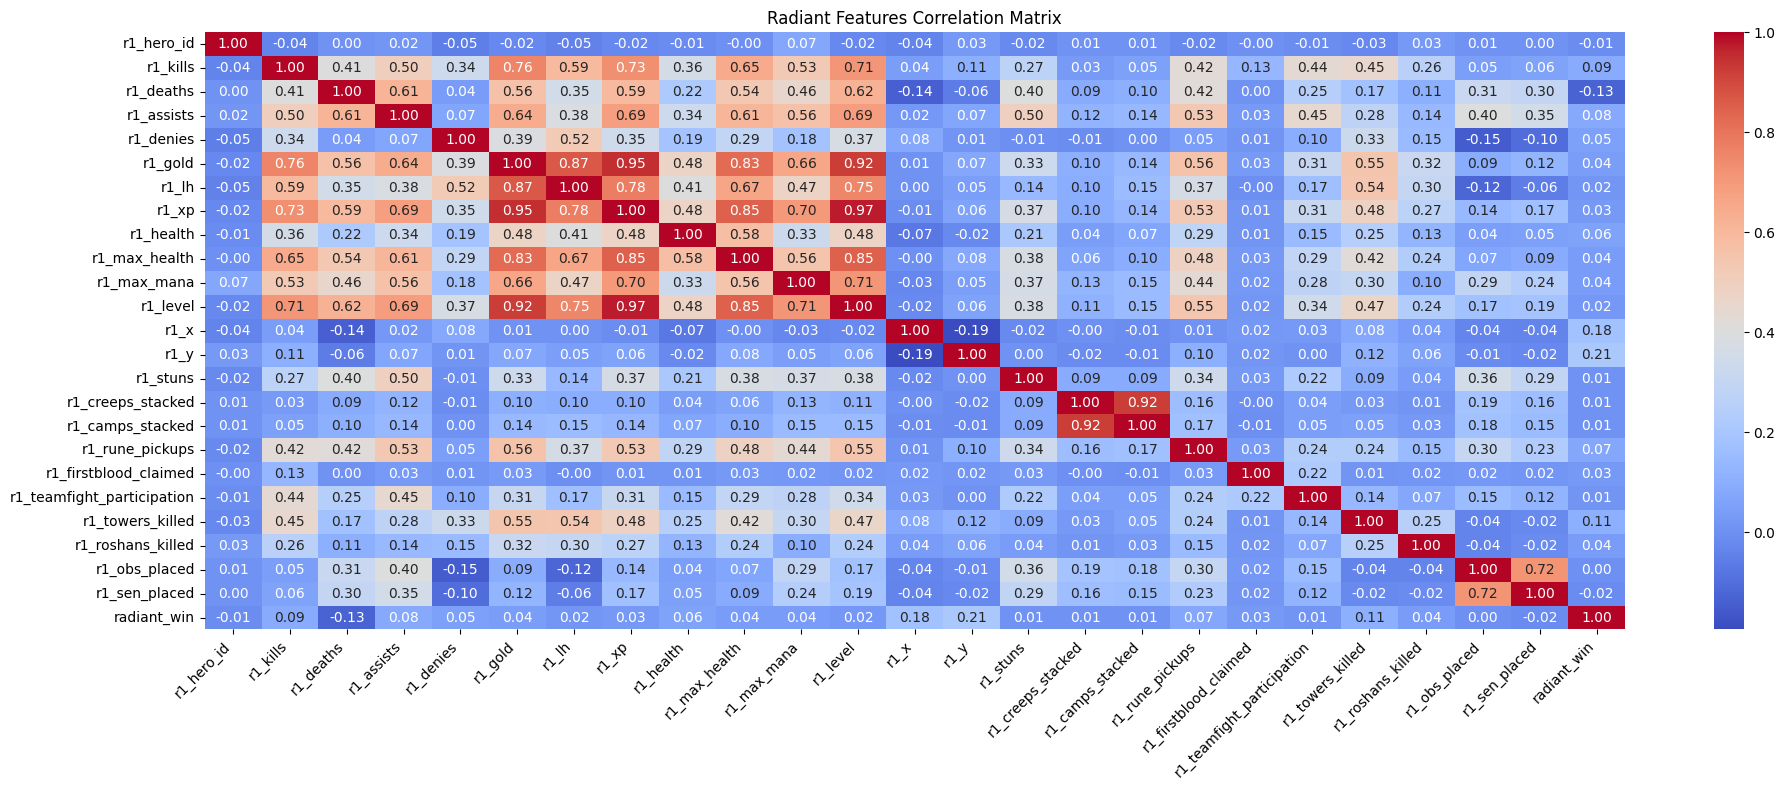

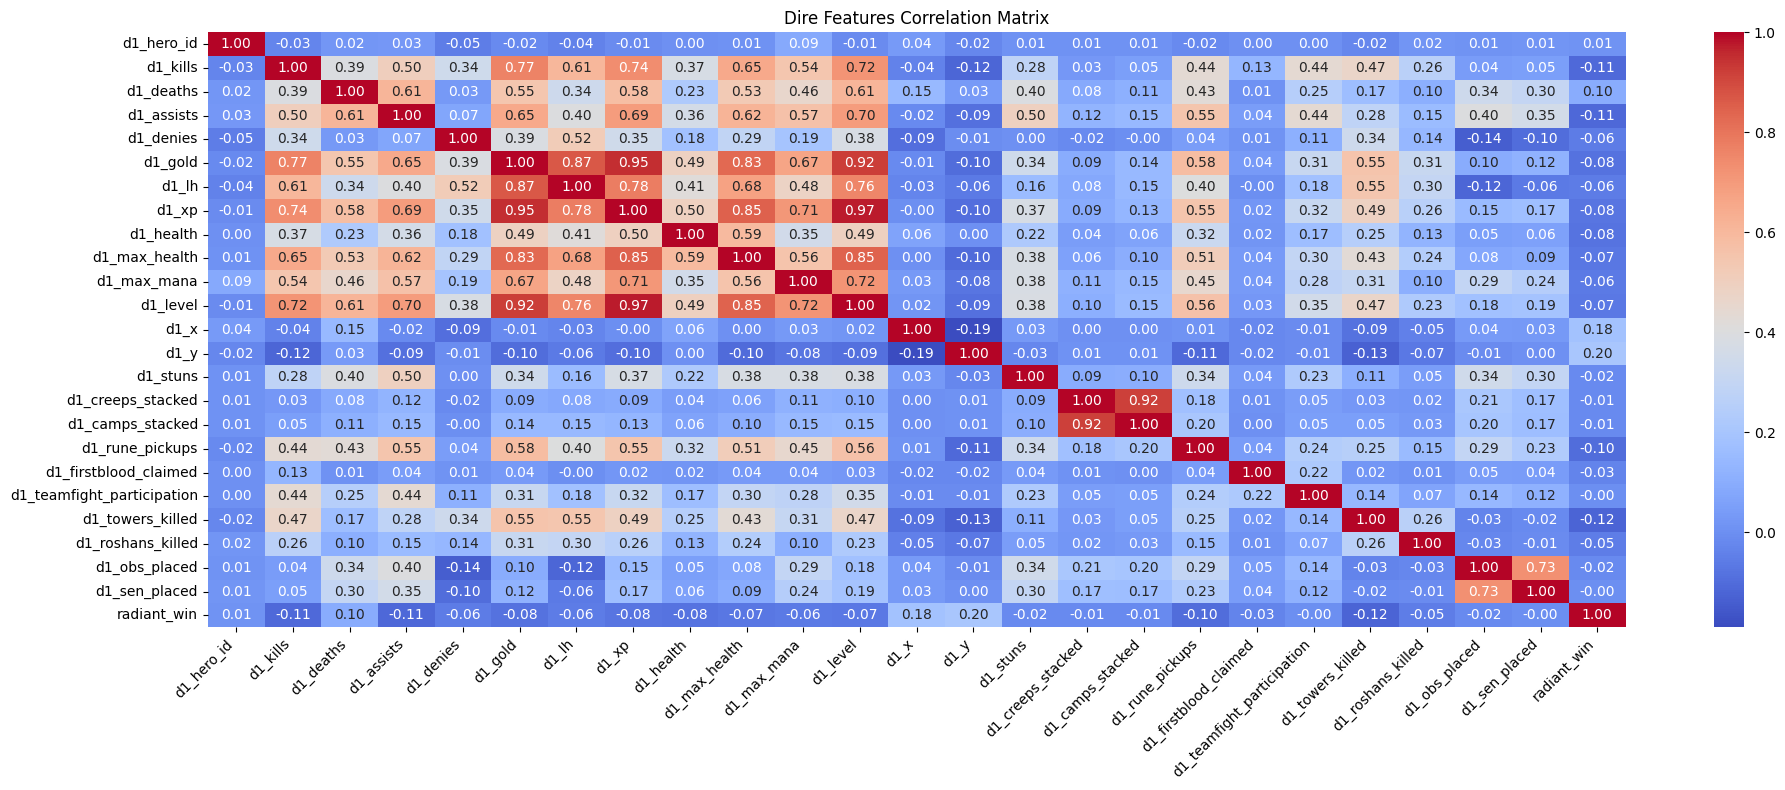

In [ ]:
radiant_features = [col for col in train_data.columns if col.startswith('r1_')] + ['radiant_win']
dire_features = [col for col in train_data.columns if col.startswith('d1_')] + ['radiant_win']

plt.figure(figsize=(20, 8))
sns.heatmap(train_data[radiant_features].corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Radiant Features Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 8))
sns.heatmap(train_data[dire_features].corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Dire Features Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Now let us check the feature distribution of the train and test sets and see how they compare with each other (they should be roughly the same).

In [ ]:
for feature in train_data.columns[:-1]:
    plt.figure(figsize=(10, 4))
    sns.histplot(train_data[feature], label='Train', kde=True, color='blue')
    sns.histplot(test_data[feature], label='Test', kde=True, color='red')
    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.show()

Let us look at the centroids and spread of heroes in a team at the given point of the game. My theory is if most radiants are centered in the top right of the map or most dires are centered in the bottom left of the map, the corresponding team is destroying the enemy's Ancient, which is the large structure located in the center of each team's base (and an ultimate goal of the game).

In [ ]:
def calculate_team_center_spread(team_coordinates):
  team = team_coordinates.columns[0][0]

  x_coordinates = team_coordinates[[cord for cord in team_coordinates if cord.endswith('_x')]]
  y_coordinates = team_coordinates[[cord for cord in team_coordinates if cord.endswith('_y')]]

  x_coordinates.columns = y_coordinates.columns
  centroid_x = x_coordinates.mean(axis=1)
  centroid_y = y_coordinates.mean(axis=1)

  spread = np.sqrt((x_coordinates.sub(centroid_x, axis=0) ** 2
                    + y_coordinates.sub(centroid_y, axis=0) ** 2).sum(axis=1)
                    / x_coordinates.shape[1])

  result = pd.DataFrame({
      f"{team}_centroid_x": centroid_x,
      f"{team}_centroid_y": centroid_y,
      f"{team}_spread": spread})

  return result

In [ ]:
coordinates_r = ['r1_x', 'r2_x', 'r3_x', 'r4_x', 'r5_x', 'r1_y', 'r2_y', 'r3_y', 'r4_y', 'r5_y']
coordinates_d = ['d1_x', 'd2_x', 'd3_x', 'd4_x', 'd5_x', 'd1_y', 'd2_y', 'd3_y', 'd4_y', 'd5_y']

center_spread_r = calculate_team_center_spread(train_data[coordinates_r])
center_spread_d = calculate_team_center_spread(train_data[coordinates_d])
train_data = pd.concat([train_data, center_spread_r, center_spread_d], axis=1)
train_data.drop(coordinates_r, axis=1, inplace=True)
train_data.drop(coordinates_d, axis=1, inplace=True)

In [ ]:
center_spread_r = calculate_team_center_spread(test_data[coordinates_r])
center_spread_d = calculate_team_center_spread(test_data[coordinates_d])
test_data = pd.concat([test_data, center_spread_r, center_spread_d], axis=1)
test_data.drop(coordinates_r, axis=1, inplace=True)
test_data.drop(coordinates_d, axis=1, inplace=True)

Now let us sum up each hero's statistics across the team to see how each team is doing compared to each other.

In [ ]:
def calculate_team_metrics(team_coordinates):
    team = team_coordinates.columns[0][0]

    metrics = ['kills', 'denies', 'gold', 'lh', 'level',
               'rune_pickups', 'towers_killed', 'roshans_killed',
               'xp', 'assists', 'stuns', 'health', 'max_mana',
               'max_health', 'creeps_stacked', 'camps_stacked',
               'teamfight_participation', 'obs_placed', 'sen_placed', 'deaths', 'firstblood_claimed']

    results = {}
    for metric in metrics:
        metric_columns = [col for col in team_coordinates if col.endswith(f"_{metric}")]
        metric_data = team_coordinates[metric_columns]

        metric_sum = metric_data.sum(axis=1)
        metric_mean = metric_data.mean(axis=1)
        metric_spread = np.sqrt((metric_data.sub(metric_mean, axis=0) ** 2).sum(axis=1)
                                / metric_data.shape[1])

        results[f"{team}_sum_{metric}"] = metric_sum
        results[f"{team}_mean_{metric}"] = metric_mean
        results[f"{team}_spread_{metric}"] = metric_spread

    result_df = pd.DataFrame(results)

    return result_df

In [ ]:
team_r = ['r1_kills', 'r2_kills', 'r3_kills', 'r4_kills', 'r5_kills',
          'r1_denies', 'r2_denies', 'r3_denies', 'r4_denies', 'r5_denies',
          'r1_gold', 'r2_gold', 'r3_gold', 'r4_gold', 'r5_gold',
          'r1_lh', 'r2_lh', 'r3_lh', 'r4_lh', 'r5_lh',
          'r1_level', 'r2_level', 'r3_level', 'r4_level', 'r5_level',
          'r1_rune_pickups', 'r2_rune_pickups', 'r3_rune_pickups', 'r4_rune_pickups', 'r5_rune_pickups',
          'r1_towers_killed', 'r2_towers_killed', 'r3_towers_killed', 'r4_towers_killed', 'r5_towers_killed',
          'r1_roshans_killed', 'r2_roshans_killed', 'r3_roshans_killed', 'r4_roshans_killed', 'r5_roshans_killed',
          'r1_xp', 'r2_xp', 'r3_xp', 'r4_xp', 'r5_xp',
          'r1_assists', 'r2_assists', 'r3_assists', 'r4_assists', 'r5_assists',
          'r1_stuns', 'r2_stuns', 'r3_stuns', 'r4_stuns', 'r5_stuns',
          'r1_health', 'r2_health', 'r3_health', 'r4_health', 'r5_health',
          'r1_max_mana', 'r2_max_mana', 'r3_max_mana', 'r4_max_mana', 'r5_max_mana',
          'r1_max_health', 'r2_max_health', 'r3_max_health', 'r4_max_health', 'r5_max_health',
          'r1_creeps_stacked', 'r2_creeps_stacked', 'r3_creeps_stacked', 'r4_creeps_stacked', 'r5_creeps_stacked',
          'r1_camps_stacked', 'r2_camps_stacked', 'r3_camps_stacked', 'r4_camps_stacked', 'r5_camps_stacked',
          'r1_teamfight_participation', 'r2_teamfight_participation', 'r3_teamfight_participation', 'r4_teamfight_participation', 'r5_teamfight_participation',
          'r1_obs_placed', 'r2_obs_placed', 'r3_obs_placed', 'r4_obs_placed', 'r5_obs_placed',
          'r1_sen_placed', 'r2_sen_placed', 'r3_sen_placed', 'r4_sen_placed', 'r5_sen_placed',
          'r1_deaths', 'r2_deaths', 'r3_deaths', 'r4_deaths', 'r5_deaths',
          'r1_firstblood_claimed', 'r2_firstblood_claimed', 'r3_firstblood_claimed', 'r4_firstblood_claimed', 'r5_firstblood_claimed']
team_d = ['d1_kills', 'd2_kills', 'd3_kills', 'd4_kills', 'd5_kills',
          'd1_denies', 'd2_denies', 'd3_denies', 'd4_denies', 'd5_denies',
          'd1_gold', 'd2_gold', 'd3_gold', 'd4_gold', 'd5_gold',
          'd1_lh', 'd2_lh', 'd3_lh', 'd4_lh', 'd5_lh',
          'd1_level', 'd2_level', 'd3_level', 'd4_level', 'd5_level',
          'd1_rune_pickups', 'd2_rune_pickups', 'd3_rune_pickups', 'd4_rune_pickups', 'd5_rune_pickups',
          'd1_towers_killed', 'd2_towers_killed', 'd3_towers_killed', 'd4_towers_killed', 'd5_towers_killed',
          'd1_roshans_killed', 'd2_roshans_killed', 'd3_roshans_killed', 'd4_roshans_killed', 'd5_roshans_killed',
          'd1_xp', 'd2_xp', 'd3_xp', 'd4_xp', 'd5_xp',
          'd1_assists', 'd2_assists', 'd3_assists', 'd4_assists', 'd5_assists',
          'd1_stuns', 'd2_stuns', 'd3_stuns', 'd4_stuns', 'd5_stuns',
          'd1_health', 'd2_health', 'd3_health', 'd4_health', 'd5_health',
          'd1_max_mana', 'd2_max_mana', 'd3_max_mana', 'd4_max_mana', 'd5_max_mana',
          'd1_max_health', 'd2_max_health', 'd3_max_health', 'd4_max_health', 'd5_max_health',
          'd1_creeps_stacked', 'd2_creeps_stacked', 'd3_creeps_stacked', 'd4_creeps_stacked', 'd5_creeps_stacked',
          'd1_camps_stacked', 'd2_camps_stacked', 'd3_camps_stacked', 'd4_camps_stacked', 'd5_camps_stacked',
          'd1_teamfight_participation', 'd2_teamfight_participation', 'd3_teamfight_participation', 'd4_teamfight_participation', 'd5_teamfight_participation',
          'd1_obs_placed', 'd2_obs_placed', 'd3_obs_placed', 'd4_obs_placed', 'd5_obs_placed',
          'd1_sen_placed', 'd2_sen_placed', 'd3_sen_placed', 'd4_sen_placed', 'd5_sen_placed',
          'd1_deaths', 'd2_deaths', 'd3_deaths', 'd4_deaths', 'd5_deaths',
          'd1_firstblood_claimed', 'd2_firstblood_claimed', 'd3_firstblood_claimed', 'd4_firstblood_claimed', 'd5_firstblood_claimed']

team_results_r = calculate_team_metrics(train_data[team_r])
team_results_d = calculate_team_metrics(train_data[team_d])
train_data = pd.concat([train_data, team_results_r, team_results_d], axis=1)
train_data.drop(team_r, axis=1, inplace=True)
train_data.drop(team_d, axis=1, inplace=True)

In [ ]:
team_results_r = calculate_team_metrics(test_data[team_r])
team_results_d = calculate_team_metrics(test_data[team_d])
test_data = pd.concat([test_data, team_results_r, team_results_d], axis=1)
test_data.drop(team_r, axis=1, inplace=True)
test_data.drop(team_d, axis=1, inplace=True)

Now let us find the difference in statistics between the two teams.

In [ ]:
for stat in ['kills', 'denies', 'gold', 'lh', 'level', 'rune_pickups',
             'towers_killed', 'roshans_killed', 'xp', 'assists', 'stuns',
             'creeps_stacked', 'camps_stacked', 'teamfight_participation',
             'obs_placed', 'sen_placed', 'deaths', 'firstblood_claimed']:
    train_data[f"{stat}_diff"] = train_data[f"r_sum_{stat}"] - train_data[f"d_sum_{stat}"]
    test_data[f"{stat}_diff"] = test_data[f"r_sum_{stat}"] - test_data[f"d_sum_{stat}"]

In [ ]:
for stat in ['kills', 'denies', 'gold', 'lh', 'level', 'rune_pickups',
             'towers_killed', 'roshans_killed', 'xp', 'assists', 'stuns',
             'creeps_stacked', 'camps_stacked', 'teamfight_participation',
             'obs_placed', 'sen_placed', 'deaths', 'firstblood_claimed']:
    train_data[f"{stat}_ratio"] = train_data[f"r_sum_{stat}"] / (train_data[f"d_sum_{stat}"] + 1e-6)
    test_data[f"{stat}_ratio"] = test_data[f"r_sum_{stat}"] / (test_data[f"d_sum_{stat}"] + 1e-6)

Now let us drop some of the categorical features that do not have much of variability or are not very important in terms of an outcome of the game.

In [ ]:
train_data.drop(['game_time', 'objectives_len', 'chat_len', 'lobby_type', 'game_mode'], axis=1, inplace=True)
test_data.drop(['game_time', 'objectives_len', 'chat_len', 'lobby_type', 'game_mode'], axis=1, inplace=True)

Here we are going to look at the hero ids combination in each team. Each hero has different abilities and different winning rates but since we do not have access to this information we are just going to look at their synergy and how their presence in a team can affect the winning chances.

In [ ]:
hero_ids = ['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id',
            'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id']

N = max(train_data[hero_ids].values.ravel())
hero_matrix = pd.DataFrame(0, index=train_data.index, columns=[str(i) for i in range(1, N + 1)])

for col in hero_ids[:5]:
    hero_matrix.values[range(len(train_data)), train_data[col] - 1] = 100

for col in hero_ids[5:]:
    hero_matrix.values[range(len(train_data)), train_data[col] - 1] = -100

train_data = pd.concat([train_data, hero_matrix], axis=1)

In [ ]:
hero_matrix = pd.DataFrame(0, index=test_data.index, columns=[str(i) for i in range(1, N + 1)])

for col in hero_ids[:5]:
    hero_matrix.values[range(len(test_data)), test_data[col] - 1] = 100

for col in hero_ids[5:]:
    hero_matrix.values[range(len(test_data)), test_data[col] - 1] = -100

test_data = pd.concat([test_data, hero_matrix], axis=1)

In [ ]:
train_data.drop(columns=hero_ids, inplace=True)
test_data.drop(columns=hero_ids, inplace=True)

In [ ]:
# Here is the list of the final feature columns we have
train_data.columns.to_list()

['radiant_win',
 'r_centroid_x',
 'r_centroid_y',
 'r_spread',
 'd_centroid_x',
 'd_centroid_y',
 'd_spread',
 'r_sum_kills',
 'r_sum_denies',
 'r_sum_gold',
 'r_sum_lh',
 'r_sum_level',
 'r_sum_rune_pickups',
 'r_sum_towers_killed',
 'r_sum_roshans_killed',
 'r_sum_xp',
 'r_sum_assists',
 'r_sum_stuns',
 'r_sum_health',
 'r_sum_max_mana',
 'r_sum_max_health',
 'r_sum_creeps_stacked',
 'r_sum_camps_stacked',
 'r_sum_teamfight_participation',
 'r_sum_obs_placed',
 'r_sum_sen_placed',
 'r_sum_deaths',
 'r_sum_firstblood_claimed',
 'd_sum_kills',
 'd_sum_denies',
 'd_sum_gold',
 'd_sum_lh',
 'd_sum_level',
 'd_sum_rune_pickups',
 'd_sum_towers_killed',
 'd_sum_roshans_killed',
 'd_sum_xp',
 'd_sum_assists',
 'd_sum_stuns',
 'd_sum_health',
 'd_sum_max_mana',
 'd_sum_max_health',
 'd_sum_creeps_stacked',
 'd_sum_camps_stacked',
 'd_sum_teamfight_participation',
 'd_sum_obs_placed',
 'd_sum_sen_placed',
 'd_sum_deaths',
 'd_sum_firstblood_claimed',
 'kills_diff',
 'denies_diff',
 'gold_diff

## Model Training

In [ ]:
X = train_data.drop('radiant_win', axis=1)
y = train_data['radiant_win']

I will use CatBoostClassifier model. First I will perform hyperparameters tuning using RandomizedSearchCV in order to find the best set of hyperparameters for the model.

In [ ]:
param_distributions = {
    'learning_rate': [0.01, 0.02, 0.05],
    'depth': [3, 4, 5],
    'l2_leaf_reg': [30, 50, 70],
    'bagging_temperature': [0.2, 0.4, 0.6],
    'random_strength': [5, 9, 12],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bylevel': [0.6, 0.7, 0.8],
    'min_data_in_leaf': [1, 3, 5]
}

catboost_model = CatBoostClassifier(
    iterations=10000,
    grow_policy='SymmetricTree',
    loss_function='Logloss',
    eval_metric='Logloss',
    random_seed=42,
    verbose=1
)

random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_distributions,
    scoring='roc_auc',
    n_iter=50,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X, y)

print("Best Parameters:", random_search.best_params_)
print("Best AUC:", random_search.best_score_)

Выходные данные были обрезаны до нескольких последних строк (5000).
5104:	learn: 0.4379860	total: 1m 33s	remaining: 1m 29s
5105:	learn: 0.4379763	total: 1m 33s	remaining: 1m 29s
5106:	learn: 0.4379623	total: 1m 33s	remaining: 1m 29s
5107:	learn: 0.4379525	total: 1m 33s	remaining: 1m 29s
5108:	learn: 0.4379379	total: 1m 33s	remaining: 1m 29s
5109:	learn: 0.4379268	total: 1m 33s	remaining: 1m 29s
5110:	learn: 0.4379178	total: 1m 33s	remaining: 1m 29s
5111:	learn: 0.4379013	total: 1m 33s	remaining: 1m 29s
5112:	learn: 0.4378914	total: 1m 34s	remaining: 1m 29s
5113:	learn: 0.4378790	total: 1m 34s	remaining: 1m 29s
5114:	learn: 0.4378683	total: 1m 34s	remaining: 1m 29s
5115:	learn: 0.4378620	total: 1m 34s	remaining: 1m 29s
5116:	learn: 0.4378498	total: 1m 34s	remaining: 1m 29s
5117:	learn: 0.4378383	total: 1m 34s	remaining: 1m 29s
5118:	learn: 0.4378333	total: 1m 34s	remaining: 1m 29s
5119:	learn: 0.4378210	total: 1m 34s	remaining: 1m 29s
5120:	learn: 0.4378083	total: 1m 34s	remaining: 1m 2

Now we will train our model with the best set of hyperparameters what we found. We will also use cross-validation with 5 folds.

Fold 1:
0:	learn: 0.6907870	test: 0.6908112	best: 0.6908112 (0)	total: 63.9ms	remaining: 10m 39s
100:	learn: 0.5703713	test: 0.5735196	best: 0.5735196 (100)	total: 1.57s	remaining: 2m 34s
200:	learn: 0.5370597	test: 0.5422399	best: 0.5422399 (200)	total: 3.04s	remaining: 2m 28s
300:	learn: 0.5250504	test: 0.5314358	best: 0.5314358 (300)	total: 4.55s	remaining: 2m 26s
400:	learn: 0.5183659	test: 0.5257877	best: 0.5257877 (400)	total: 5.99s	remaining: 2m 23s
500:	learn: 0.5136741	test: 0.5219699	best: 0.5219699 (500)	total: 7.46s	remaining: 2m 21s
600:	learn: 0.5105342	test: 0.5196112	best: 0.5196112 (600)	total: 8.88s	remaining: 2m 18s
700:	learn: 0.5080056	test: 0.5177261	best: 0.5177261 (700)	total: 10.7s	remaining: 2m 22s
800:	learn: 0.5059349	test: 0.5161612	best: 0.5161612 (800)	total: 13.2s	remaining: 2m 31s
900:	learn: 0.5039267	test: 0.5147310	best: 0.5147310 (900)	total: 14.6s	remaining: 2m 27s
1000:	learn: 0.5018983	test: 0.5133906	best: 0.5133906 (1000)	total: 16.1s	remaining

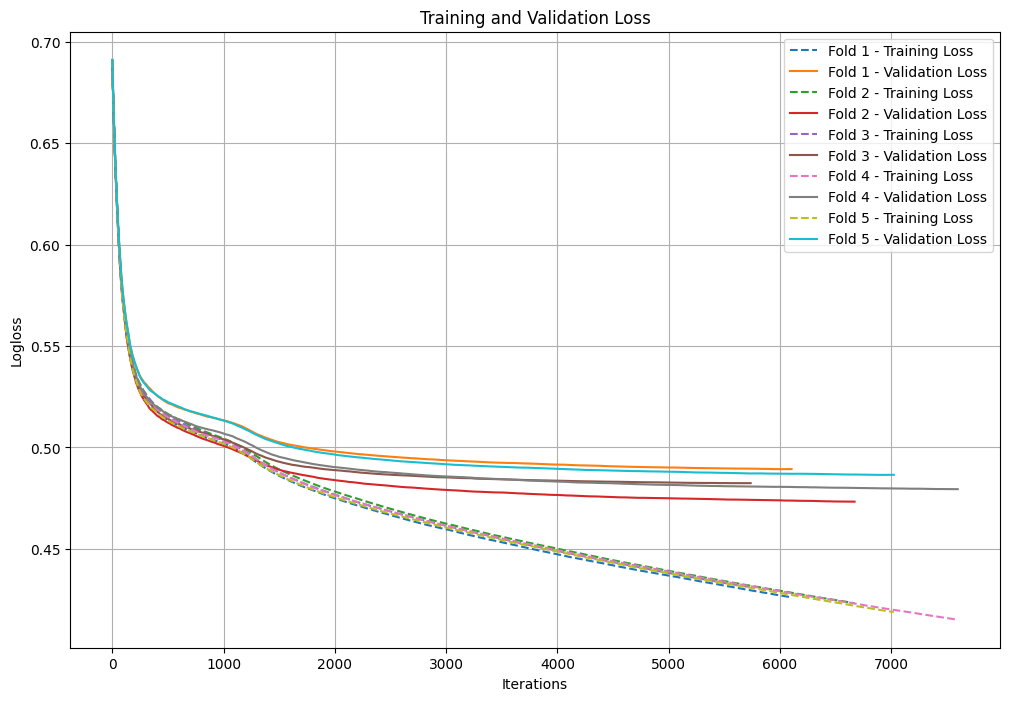

Mean AUC: 0.8427 (±0.0037)
Mean Accuracy: 0.7515 (±0.0022)
0:	learn: 0.6908726	total: 18.6ms	remaining: 3m 6s
100:	learn: 0.5698388	total: 1.78s	remaining: 2m 54s
200:	learn: 0.5366939	total: 3.49s	remaining: 2m 50s
300:	learn: 0.5250226	total: 6.64s	remaining: 3m 33s
400:	learn: 0.5187353	total: 8.35s	remaining: 3m 19s
500:	learn: 0.5147915	total: 10s	remaining: 3m 10s
600:	learn: 0.5117256	total: 11.7s	remaining: 3m 3s
700:	learn: 0.5092461	total: 13.4s	remaining: 2m 58s
800:	learn: 0.5072030	total: 15.1s	remaining: 2m 53s
900:	learn: 0.5051341	total: 17.2s	remaining: 2m 53s
1000:	learn: 0.5031841	total: 19.9s	remaining: 2m 59s
1100:	learn: 0.5009292	total: 21.7s	remaining: 2m 55s
1200:	learn: 0.4979792	total: 23.3s	remaining: 2m 50s
1300:	learn: 0.4945412	total: 25s	remaining: 2m 47s
1400:	learn: 0.4912929	total: 26.8s	remaining: 2m 44s
1500:	learn: 0.4885248	total: 28.5s	remaining: 2m 41s
1600:	learn: 0.4861627	total: 31.5s	remaining: 2m 45s
1700:	learn: 0.4840082	total: 33.3s	rema

In [ ]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

auc_scores = []
train_loss_graph = []
val_loss_graph = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}:")

    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    catboost_model = CatBoostClassifier(
        iterations=10000,
        learning_rate=0.01,
        depth=4,
        l2_leaf_reg=30,
        bagging_temperature=0.4,
        random_strength=9,
        subsample=0.5,
        colsample_bylevel=0.6,
        min_data_in_leaf=1,
        grow_policy='SymmetricTree',
        loss_function='Logloss',
        eval_metric='Logloss',
        random_seed=42,
        verbose=100
    )

    catboost_model.fit(
        X_train_fold, y_train_fold,
        eval_set=(X_val_fold, y_val_fold),
        use_best_model=True,
        early_stopping_rounds=100
    )

    evals_result = catboost_model.evals_result_
    train_loss = evals_result['learn']['Logloss']
    val_loss = evals_result['validation']['Logloss']

    train_loss_graph.append(train_loss)
    val_loss_graph.append(val_loss)

    y_val_proba = catboost_model.predict_proba(X_val_fold)[:, 1]

    auc = roc_auc_score(y_val_fold, y_val_proba)
    y_val_pred = catboost_model.predict(X_val_fold)

    auc_scores.append(auc)

    print(f"Fold {fold + 1} AUC: {auc:.4f}")

plt.figure(figsize=(12, 8))
for fold in range(n_splits):
    plt.plot(train_loss_graph[fold], label=f'Fold {fold + 1} - Training Loss', linestyle='--')
    plt.plot(val_loss_graph[fold], label=f'Fold {fold + 1} - Validation Loss', linestyle='-')

plt.xlabel('Iterations')
plt.ylabel('Logloss')
plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.grid()
plt.show()

mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print(f"Mean AUC: {mean_auc:.4f} (±{std_auc:.4f})")

final_model = CatBoostClassifier(
      iterations=10000,
      learning_rate=0.01,
      depth=4,
      l2_leaf_reg=30,
      bagging_temperature=0.4,
      random_strength=9,
      subsample=0.5,
      colsample_bylevel=0.6,
      min_data_in_leaf=1,
      grow_policy='SymmetricTree',
      loss_function='Logloss',
      eval_metric='Logloss',
      random_seed=42,
      verbose=100
    )

final_model.fit(X, y, early_stopping_rounds=100)

Now let us look at the feature importance graph for our model.

<ipython-input-33-58f2dc364ab8>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


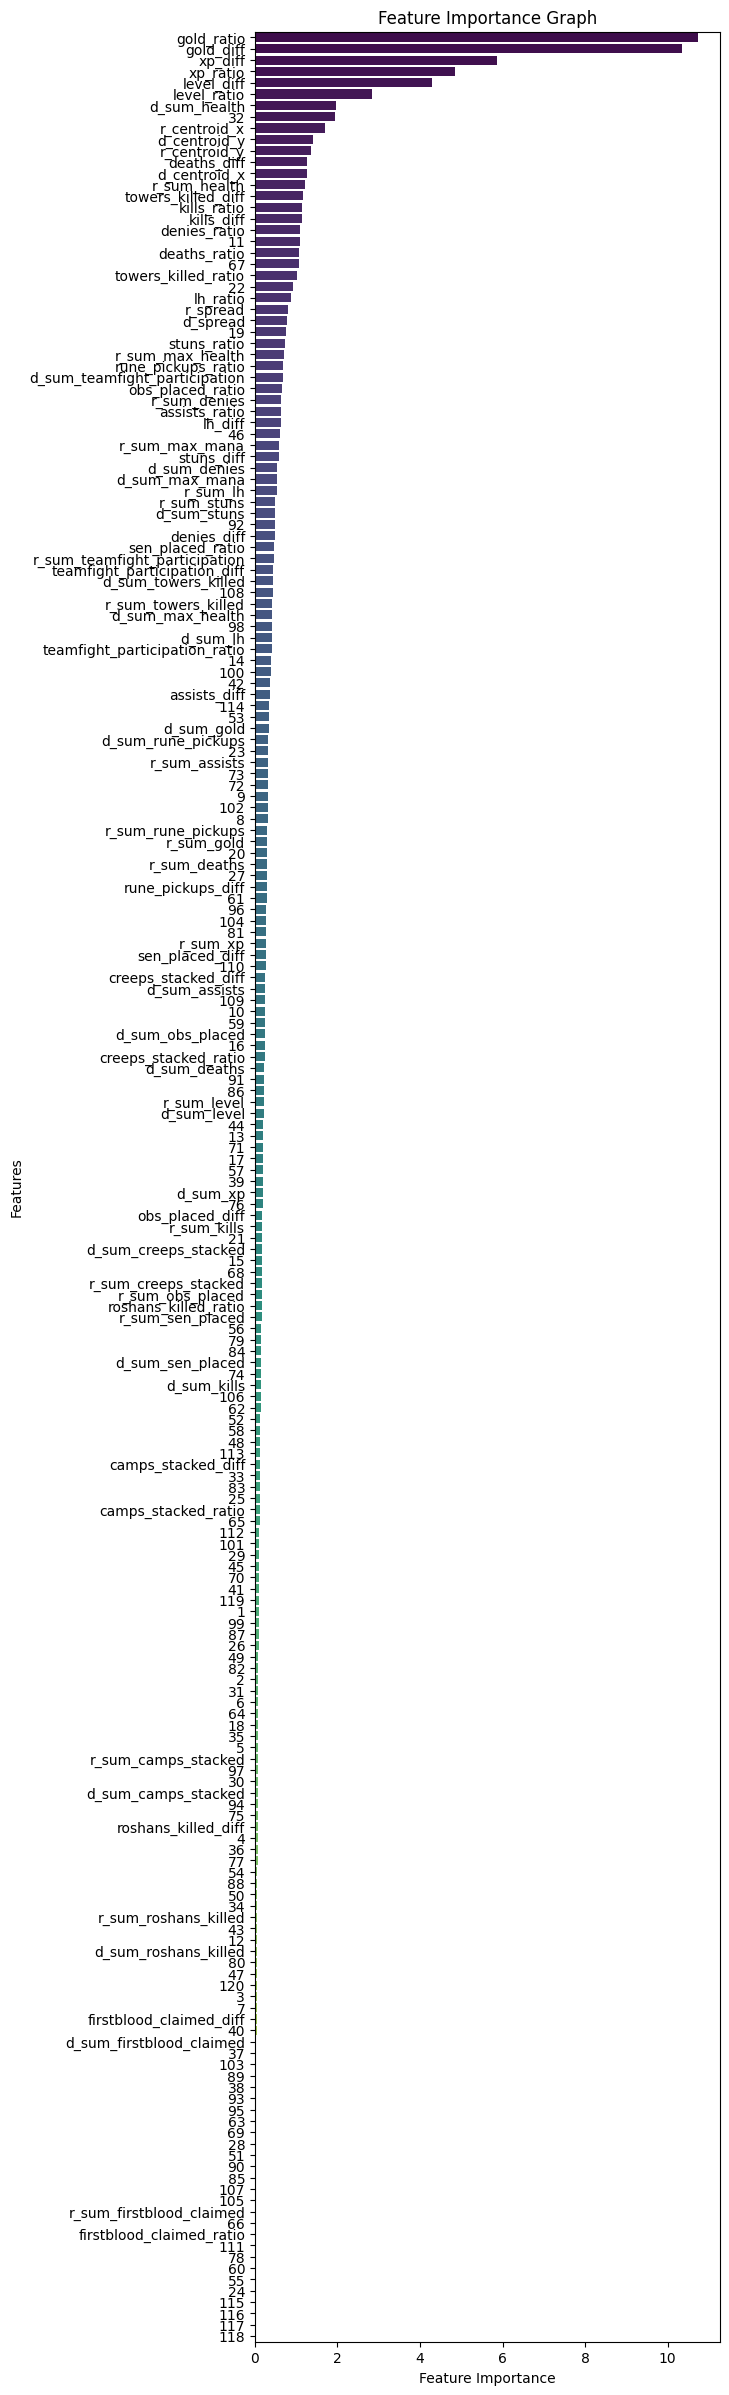

In [ ]:
feature_importance = final_model.get_feature_importance()
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 30))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Graph')
plt.show()

As we can see, many features are not important for the model. Let us try to perform feature reduction and check whether it can help improve model's performance. For that, let us add 10 features at a time and check AUC score for every feature set.

Features: 10, AUC: 0.8248
Features: 20, AUC: 0.8293
Features: 30, AUC: 0.8341
Features: 40, AUC: 0.8357
Features: 50, AUC: 0.8373
Features: 60, AUC: 0.8387
Features: 70, AUC: 0.8403
Features: 80, AUC: 0.8412
Features: 90, AUC: 0.8418
Features: 100, AUC: 0.8421
Features: 110, AUC: 0.8425
Features: 120, AUC: 0.8424
Features: 130, AUC: 0.8427
Features: 140, AUC: 0.8423
Features: 150, AUC: 0.8422
Features: 160, AUC: 0.8429
Features: 170, AUC: 0.8423
Features: 180, AUC: 0.8423
Features: 190, AUC: 0.8426
Features: 200, AUC: 0.8425


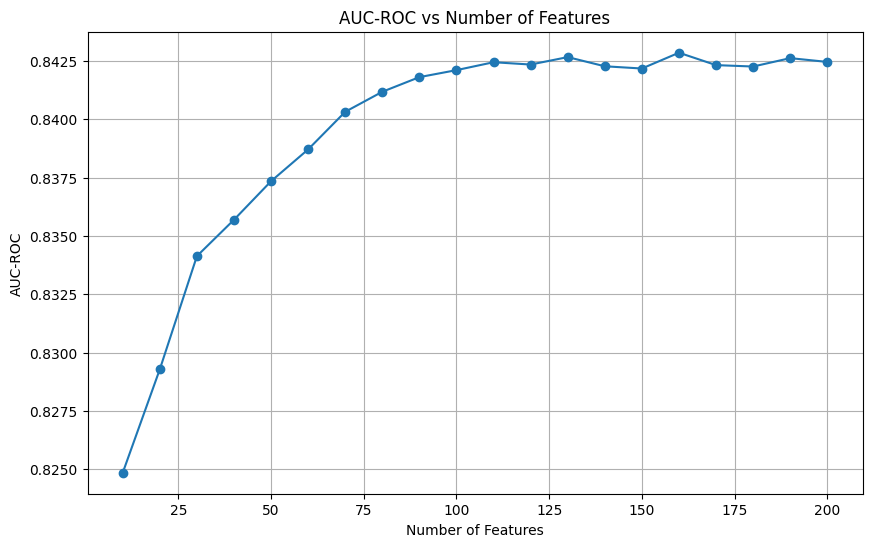

Optimal Number of Features: 160 with AUC-ROC: 0.8429


In [ ]:
features = range(10, len(feature_importance_df['Feature']), 10)

auc_results = []

for feature in features:
    features_to_use = feature_importance_df['Feature'].iloc[:feature].values
    X_filtered = X[features_to_use]

    auc_scores = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_filtered, y):
        X_train, X_val = X_filtered.iloc[train_idx], X_filtered.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        catboost_model = CatBoostClassifier(
            iterations=10000,
            learning_rate=0.01,
            depth=4,
            l2_leaf_reg=30,
            bagging_temperature=0.4,
            random_strength=9,
            subsample=0.5,
            colsample_bylevel=0.6,
            min_data_in_leaf=1,
            grow_policy='SymmetricTree',
            loss_function='Logloss',
            eval_metric='AUC',
            random_seed=42,
            verbose=0
        )

        catboost_model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
            use_best_model=True,
            early_stopping_rounds=100
        )

        y_val_proba = catboost_model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_val_proba)
        auc_scores.append(auc)

    mean_auc = np.mean(auc_scores)
    auc_results.append(mean_auc)

    print(f"Features: {feature}, AUC: {mean_auc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(features, auc_results, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC vs Number of Features')
plt.grid()
plt.show()

optimal_result = np.argmax(auc_results)
optimal_features = features[optimal_result]
optimal_auc = auc_results[optimal_result]

print(f"Optimal Number of Features: {optimal_features} with AUC-ROC: {optimal_auc:.4f}")

We have the highest AUC score with the first 160 most important features, so let us adjust our dataset accordingly.

<ipython-input-34-45749d272a1e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.iloc[:140], palette='viridis')


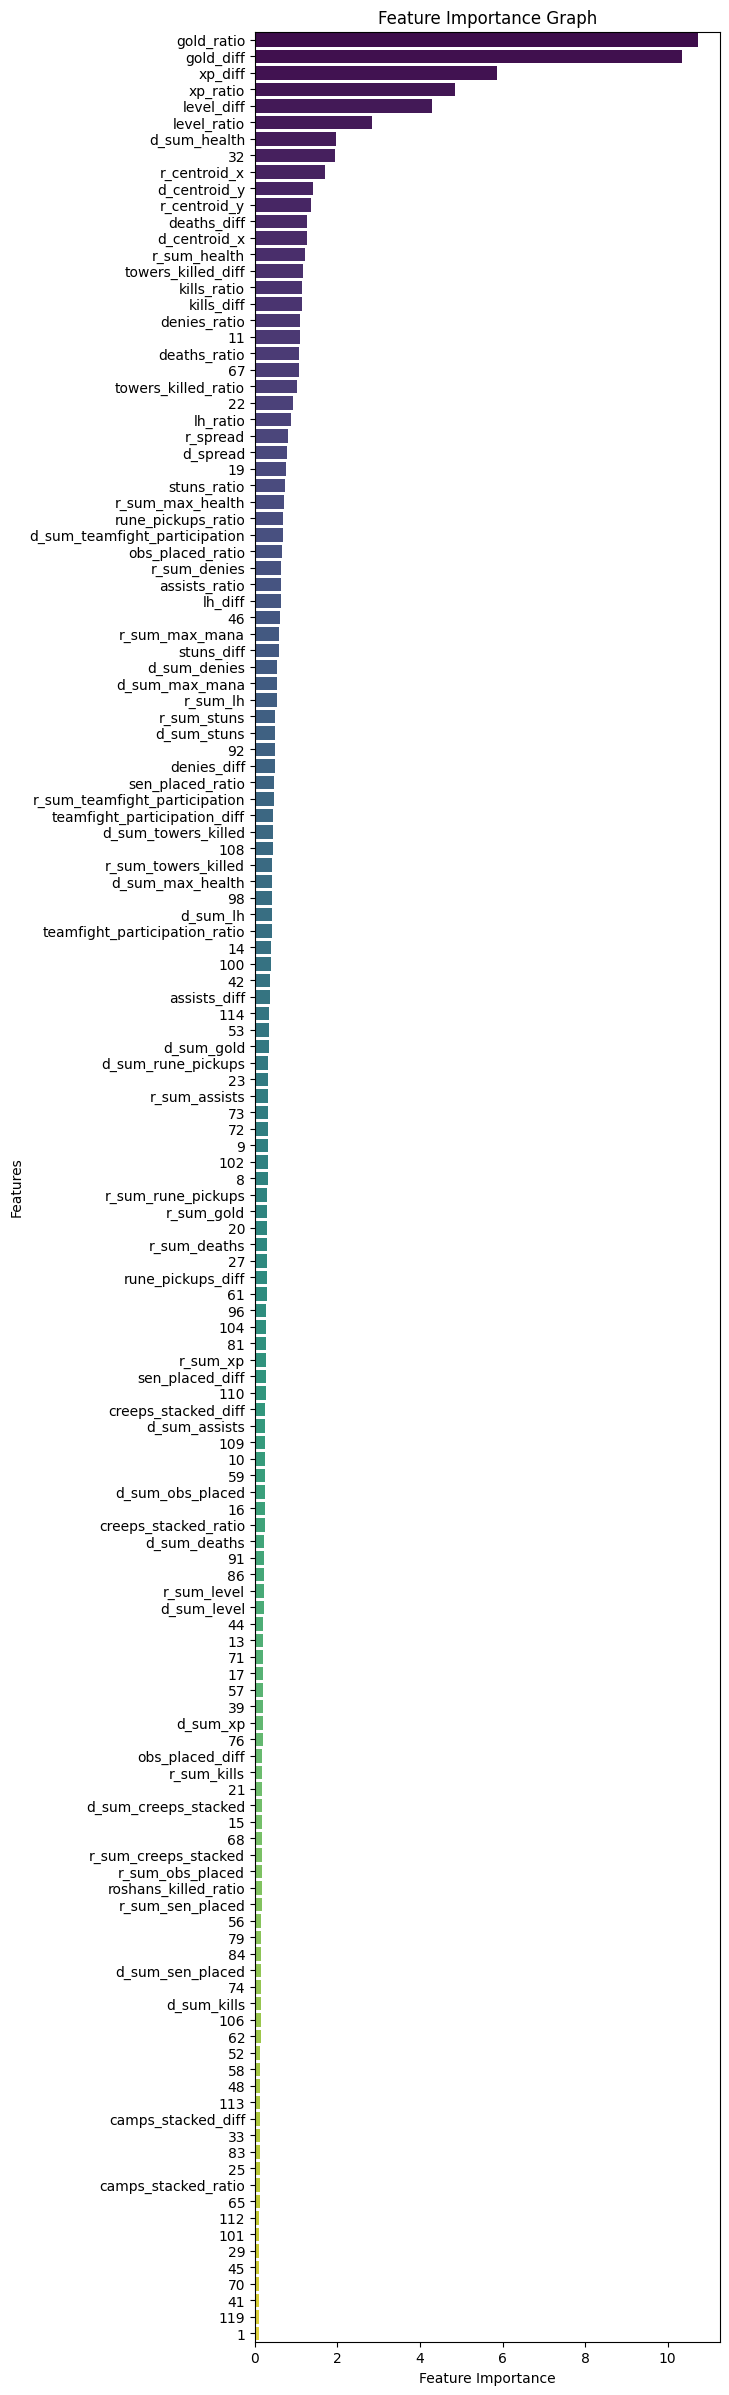

In [ ]:
features_to_save = feature_importance_df['Feature'].iloc[:160].values
X_filtered = X[features_to_save]

plt.figure(figsize=(6, 30))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.iloc[:160], palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Graph')
plt.show()

Fold 1:
0:	learn: 0.6905406	test: 0.6905790	best: 0.6905790 (0)	total: 14.2ms	remaining: 2m 22s
100:	learn: 0.5653511	test: 0.5684975	best: 0.5684975 (100)	total: 1.42s	remaining: 2m 19s
200:	learn: 0.5333858	test: 0.5388549	best: 0.5388549 (200)	total: 2.75s	remaining: 2m 14s
300:	learn: 0.5217158	test: 0.5285615	best: 0.5285615 (300)	total: 4.09s	remaining: 2m 11s
400:	learn: 0.5158731	test: 0.5238632	best: 0.5238632 (400)	total: 5.44s	remaining: 2m 10s
500:	learn: 0.5116298	test: 0.5203548	best: 0.5203532 (499)	total: 6.75s	remaining: 2m 8s
600:	learn: 0.5084175	test: 0.5179095	best: 0.5179095 (600)	total: 8.56s	remaining: 2m 13s
700:	learn: 0.5062663	test: 0.5163224	best: 0.5163224 (700)	total: 10.8s	remaining: 2m 23s
800:	learn: 0.5041848	test: 0.5147509	best: 0.5147509 (800)	total: 12.1s	remaining: 2m 19s
900:	learn: 0.5017282	test: 0.5129957	best: 0.5129957 (900)	total: 13.5s	remaining: 2m 16s
1000:	learn: 0.4995443	test: 0.5114210	best: 0.5114210 (1000)	total: 14.9s	remaining: 

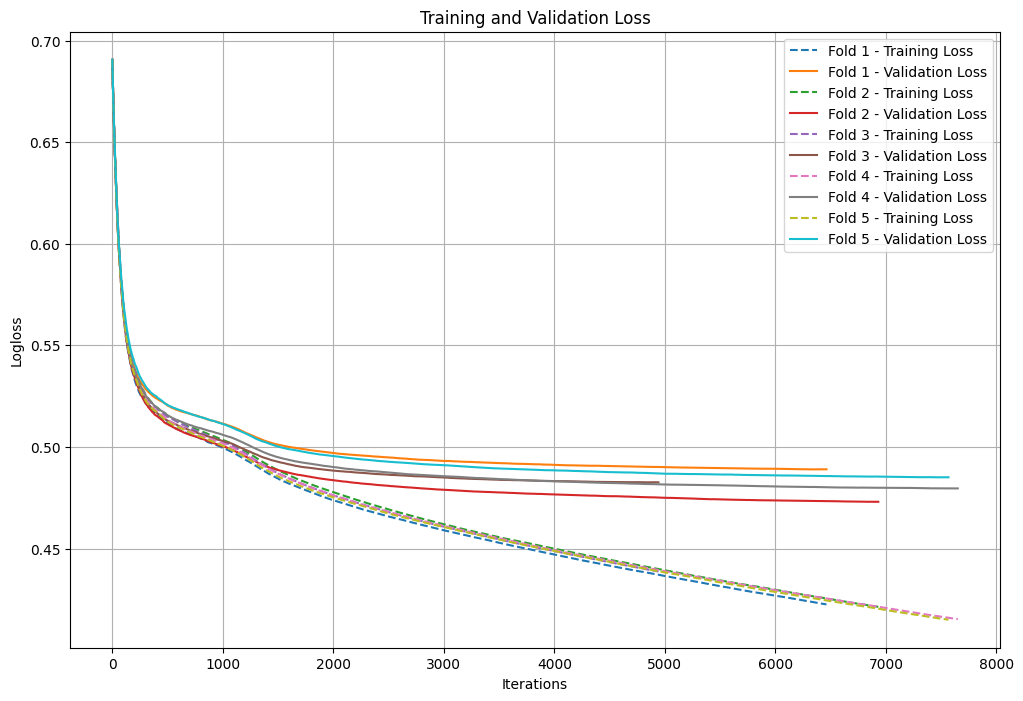

Mean AUC: 0.8430 (±0.0034)
Mean Accuracy: 0.7520 (±0.0021)
0:	learn: 0.6905499	total: 19ms	remaining: 3m 10s
100:	learn: 0.5677347	total: 1.6s	remaining: 2m 36s
200:	learn: 0.5357426	total: 3.15s	remaining: 2m 33s
300:	learn: 0.5234209	total: 4.7s	remaining: 2m 31s
400:	learn: 0.5168704	total: 7.71s	remaining: 3m 4s
500:	learn: 0.5126571	total: 9.24s	remaining: 2m 55s
600:	learn: 0.5095699	total: 10.8s	remaining: 2m 48s
700:	learn: 0.5072098	total: 12.3s	remaining: 2m 42s
800:	learn: 0.5050608	total: 13.8s	remaining: 2m 38s
900:	learn: 0.5031352	total: 15.3s	remaining: 2m 34s
1000:	learn: 0.5010921	total: 16.9s	remaining: 2m 31s
1100:	learn: 0.4990124	total: 19.8s	remaining: 2m 40s
1200:	learn: 0.4964211	total: 21.4s	remaining: 2m 36s
1300:	learn: 0.4933225	total: 22.9s	remaining: 2m 33s
1400:	learn: 0.4903360	total: 24.4s	remaining: 2m 29s
1500:	learn: 0.4878381	total: 26s	remaining: 2m 27s
1600:	learn: 0.4854638	total: 27.5s	remaining: 2m 24s
1700:	learn: 0.4833657	total: 29.1s	remai

In [ ]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

auc_scores = []
train_loss_graph = []
val_loss_graph = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_filtered, y)):
    print(f"Fold {fold + 1}:")

    X_train_fold, X_val_fold = X_filtered.iloc[train_idx], X_filtered.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    catboost_model = CatBoostClassifier(
        iterations=10000,
        learning_rate=0.01,
        depth=4,
        l2_leaf_reg=30,
        bagging_temperature=0.4,
        random_strength=9,
        subsample=0.5,
        colsample_bylevel=0.6,
        min_data_in_leaf=1,
        grow_policy='SymmetricTree',
        loss_function='Logloss',
        eval_metric='Logloss',
        random_seed=42,
        verbose=100
    )

    catboost_model.fit(
        X_train_fold, y_train_fold,
        eval_set=(X_val_fold, y_val_fold),
        use_best_model=True,
        early_stopping_rounds=100
    )

    evals_result = catboost_model.evals_result_
    train_loss = evals_result['learn']['Logloss']
    val_loss = evals_result['validation']['Logloss']

    train_loss_graph.append(train_loss)
    val_loss_graph.append(val_loss)

    y_val_proba = catboost_model.predict_proba(X_val_fold)[:, 1]

    auc = roc_auc_score(y_val_fold, y_val_proba)
    y_val_pred = catboost_model.predict(X_val_fold)

    auc_scores.append(auc)

    print(f"Fold {fold + 1} - AUC: {auc:.4f}")

plt.figure(figsize=(12, 8))
for fold in range(n_splits):
    plt.plot(train_loss_graph[fold], label=f'Fold {fold + 1} - Training Loss', linestyle='--')
    plt.plot(val_loss_graph[fold], label=f'Fold {fold + 1} - Validation Loss', linestyle='-')

plt.xlabel('Iterations')
plt.ylabel('Logloss')
plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.grid()
plt.show()

mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print(f"Mean AUC: {mean_auc:.4f} (±{std_auc:.4f})")

final_model = CatBoostClassifier(
      iterations=10000,
      learning_rate=0.01,
      depth=4,
      l2_leaf_reg=30,
      bagging_temperature=0.4,
      random_strength=9,
      subsample=0.5,
      colsample_bylevel=0.6,
      min_data_in_leaf=1,
      grow_policy='SymmetricTree',
      loss_function='Logloss',
      eval_metric='Logloss',
      random_seed=42,
      verbose=100
)

final_model.fit(X_filtered, y, early_stopping_rounds=100)

In [ ]:
# Adjust the test set accordingly
test_data = test_data[features_to_save]

## Upload Results

In [ ]:
y_test_pred = final_model.predict_proba(test_data)[:, 1]

In [ ]:
submission_array = np.vstack([test_ids.values.flatten(), y_test_pred]).T
submission_df = pd.DataFrame(submission_array, columns=['ID', 'radiant_win']).reset_index(drop=True)
submission_df.to_csv('simple_baseline.csv', index=None)

In [ ]:
submission_df

,ID,radiant_win
0,a400b8f29dece5f4d266f49f1ae2e98a,0.128105
1,34c81a8faede0d8f1f87dcc6ee824658,0.379143
2,5feece770ca79e5e8cd8052198b3f533,0.446417
3,8f56cc2468ba5c37edb79f3a7b4af6e6,0.008069
4,44cdded6d3311134563f743eb77685b2,0.178235
...,...,...
9995,308faee28efee2e66b39f9f2ba6ea9cf,0.978483
9996,6066cc7417b43c749d551e123d00f0c8,0.182213
9997,e2ca68ac1a6847f4a37f6c9c8ee8695b,0.071845
9998,47ad6454ede66c1c78fdaa9391dfc556,0.940116
